# Clasificación de minas y rocas en base a mediciones de sonar

## 1. Definición del problema

El presente proyecto busca encontrar un modelo capaz de determinar en la forma más precisa posible si un objeto detectado por un sonar es una mina o una roca. Dicho objeto estará definido por un conjunto de mediciones que han sido previamente recolectadas por el sonar.

Con el modelo resultante, se espera lograr una oportuna detección de la existencia de minas en determinadas zonas geográficas, especialmente en aquellas altamente pobladas.

## 2. Descripción de datos

### 2.1 Carga de datos

Primero, se importan los diferentes modulos que se usarán a lo largo del proyecto. Luego, se carga el conjunto de datos que servirá para entrenar y evaluar los diferentes modelos candidatos.

In [1]:
# Load libraries
import numpy
numpy.random.seed(7)

import pandas
from pandas import read_csv
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier as GB

import logging
logging.getLogger('tensorflow').disabled = True

import tensorflow
tensorflow.random.set_seed(7)

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
import pickle

In [2]:
# Load dataset
filename = 'sonar.all-data'
dataset = read_csv(filename, header=None)

### 2.2 Variables independientes

Cada observación del conjunto de datos está definido por 60 atributos. A su vez, cada atributo representa la energía contenida dentro de una banda de frecuencia determinada, integrada sobre un cierto periodo de tiempo.

### 2.3 Variable dependiente

La variable dependiente corresponde a la categoría o clase del objeto detectado. Dicha objeto puede pertenecer a una y solo una de las siguientes categorías:

- Mina
- Roca

### 2.4 Estadísticas descriptivas

#### 2.4.1 Dimensiones del dataset

In [3]:
# Print data shape
rows, columns = dataset.shape
print('El dataset está compuesto por', rows, 'observaciones y', columns, 'columnas (', columns - 1,
      'atributos más la variable a predecir).')

El dataset está compuesto por 208 observaciones y 61 columnas ( 60 atributos más la variable a predecir).


#### 2.4.2 Características de atributos

Por cada atributo, se indica la cantidad de valores nulos y su tipo de dato.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

Luego, cada atributo es de tipo punto flotante y no posee valores nulos. Por otra parte, la variable dependiente es leída como un objeto.

#### 2.4.3 Resumen estadístico de atributos

A continuación, se muestra el valor promedio, la desviación estándar, el valor mínimo, los percentiles 25, 50 y 75 y el valor máximo de cada atributo.

In [5]:
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


Se observa que todos los valores son mayores o iguales que cero, pero menores que uno, por lo que se puede decir que se encuentran en escalas similares.

#### 2.4.4 Un vistazo de los datos

Se muestran las primeras cinco observaciones del dataset, en conjunto con las observaciones 96 a la 100, cada una de ellas definida por sus atributos y su categoría.

In [6]:
dataset.head(100)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0291,0.0400,0.0771,0.0809,0.0521,0.1051,0.0145,0.0674,0.1294,0.1146,...,0.0056,0.0237,0.0204,0.0050,0.0137,0.0164,0.0081,0.0139,0.0111,R
96,0.0181,0.0146,0.0026,0.0141,0.0421,0.0473,0.0361,0.0741,0.1398,0.1045,...,0.0223,0.0255,0.0145,0.0233,0.0041,0.0018,0.0048,0.0089,0.0085,R
97,0.0491,0.0279,0.0592,0.1270,0.1772,0.1908,0.2217,0.0768,0.1246,0.2028,...,0.0081,0.0129,0.0161,0.0063,0.0119,0.0194,0.0140,0.0332,0.0439,M
98,0.1313,0.2339,0.3059,0.4264,0.4010,0.1791,0.1853,0.0055,0.1929,0.2231,...,0.0362,0.0210,0.0154,0.0180,0.0013,0.0106,0.0127,0.0178,0.0231,M


Es importante notar que la columna correspondiente a la variable dependiente es en definitiva de tipo string y sus posibles valores son 'R' (roca) y 'M' (mina).

#### 2.4.5 Distribución de clases

In [7]:
for class_name, class_group in dataset.groupby(60):
    print('Clase:', class_name)
    print('Número de instancias:', len(class_group))
    print('Porcentaje de instancias respecto al total:', 
          round(100.0 * len(class_group) / dataset.shape[0], 2), '%')
    print('')

Clase: M
Número de instancias: 111
Porcentaje de instancias respecto al total: 53.37 %

Clase: R
Número de instancias: 97
Porcentaje de instancias respecto al total: 46.63 %



Se puede ver que existe una mayor cantidad de observaciones etiquetadas como mina. A pesar de ello, es posible decir que las clases están razonablemente balanceadas.

## 3 Visualización de datos

### 3.1 Gráficos univariados

Por cada atributo, se crea un histograma para así tener una idea básica de como se distribuyen sus valores.

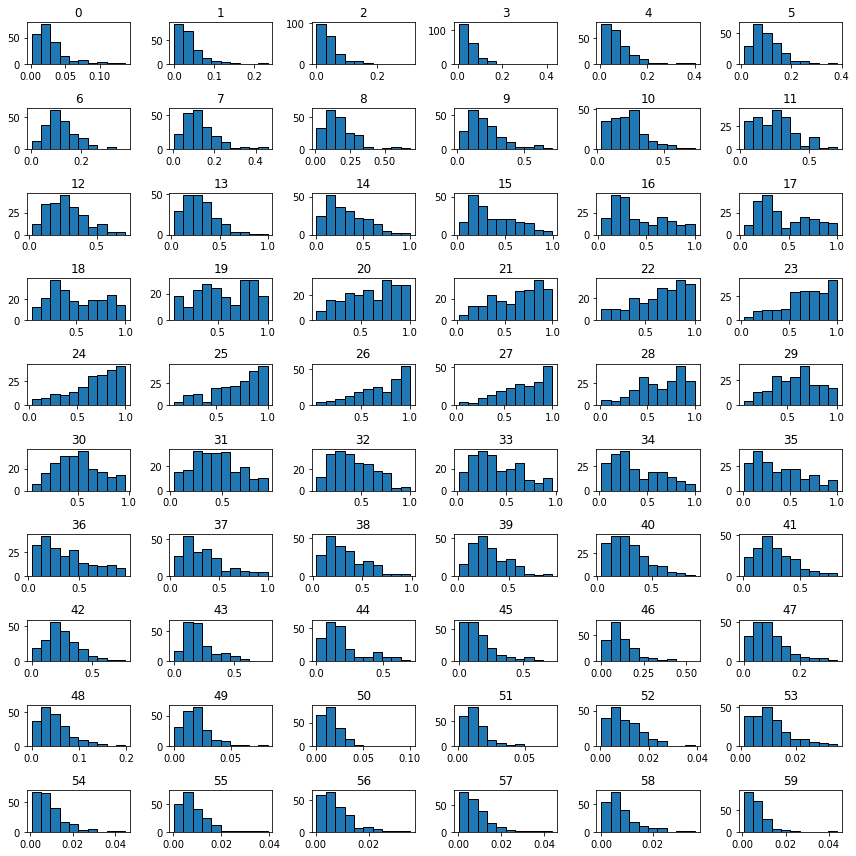

In [8]:
# Histogram by attribute
_, axes = pyplot.subplots(10, 6, figsize=(12, 12))
axes = axes.ravel()

for (col_num, ax) in zip(dataset.columns[:-1], axes):
    ax.set_title(col_num)
    ax.hist(dataset.iloc[:, col_num], histtype='bar', ec='black')
  
pyplot.tight_layout()

Se observa una amplia variedad en las distribuciones de los atributos, existiendo, por ejemplo, distribuciones que parecen ser exponenciales (como las de los atributos 1, 2, 3 y 4) y otras que parecen ser gaussianas (aunque sesgadas, como las de los atributos 6, 7 y 8).

También, por cada atributo, se crea un boxplot para visualizar que tanto varían sus valores y la posible presencia de outliers.

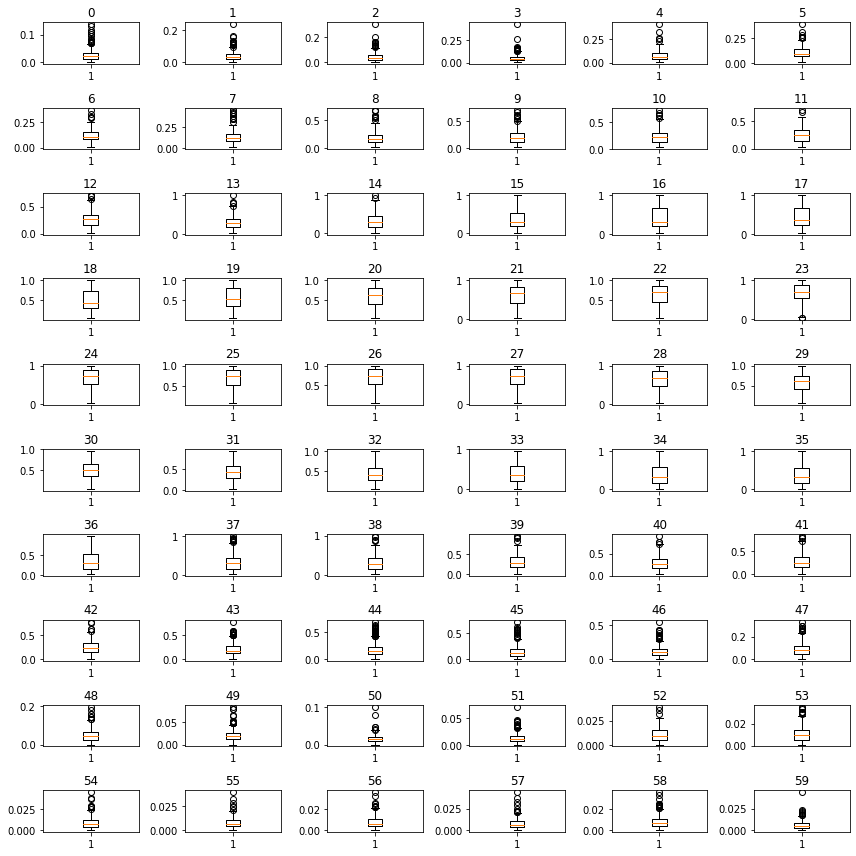

In [9]:
# Boxplot by attribute
_, axes = pyplot.subplots(10, 6, figsize=(12, 12))
axes = axes.ravel()

for (col_num, ax) in zip(dataset.columns[:-1], axes):
    ax.set_title(col_num)
    ax.boxplot(dataset.iloc[:, col_num])
  
pyplot.tight_layout()

Se observa que la forma en que varían los valores de cada atributo puede ser muy diferente. En algunos atributos, los valores se concentran dentro de rangos bastante acotados (como por ejemplo, en los primeros ocho atributos), mientras que en otros, los rangos de valores son más amplios (como en los atributos 16 a 22). De igual forma, se observa que en algunos atributos, la presencia de outliers es nula, mientras que en otros no.

### 3.2 Gráficos multivariados

Se procede a construir gráficos que permitan visualizar las interacciones entre las variables del problema.

En primer lugar, se visualizan las correlaciones existentes entre atributos.

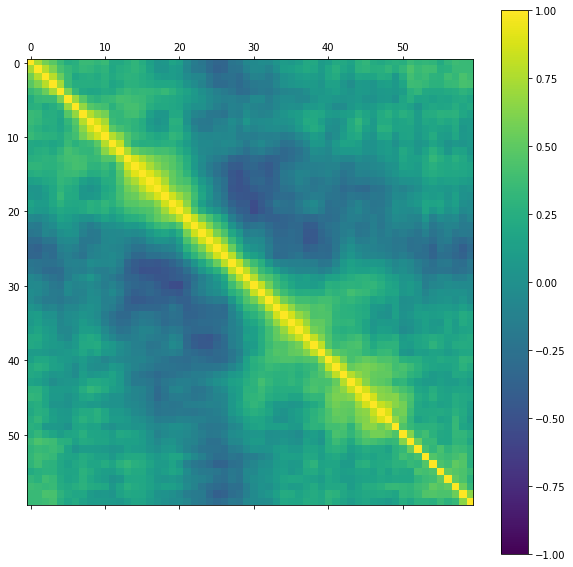

In [10]:
# Correlation matrix
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
pyplot.show()

La figura da cuenta de la existencia de fuertes correlaciones positivas entre atributos adyacentes, mientras que entre atributos más "lejanos", las correlaciones tienden a ser negativas y más débiles.

Finalmente, se crea un histograma para ilustrar la distribución de clases de cada atributo. Para una mejor visualización, sólo se mostrarán los primeros 16 atributos.

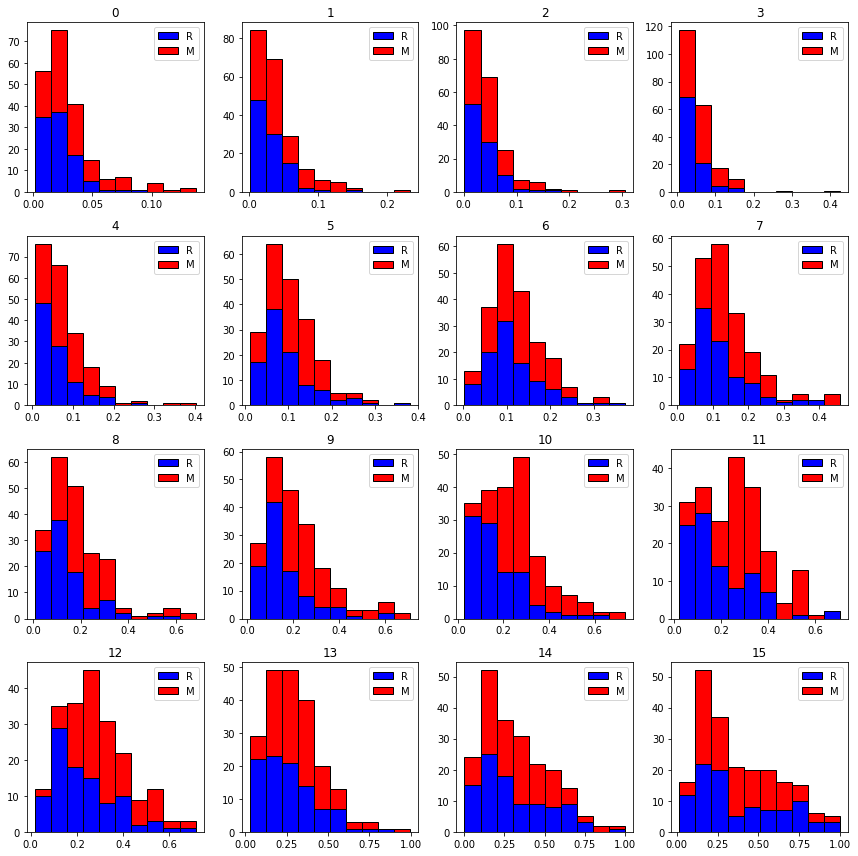

In [12]:
# Stacked histogram of each attribute by class
_, axes = pyplot.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for (col_num, ax) in zip(dataset.columns[:16], axes):
    ax.set_title(col_num)
    ax.hist([dataset.loc[dataset.iloc[:, -1] == x, col_num] for x in classes],
            histtype='bar', ec='black', stacked=True, 
            color=list(color_wheel.values()), label=list(classes))
    ax.legend(classes)

pyplot.tight_layout()

En general, se observa que para los valores más pequeños de cada atributo no se presenta un patrón claro en la distribución de clases: en algunos casos, la clase 'roca' es más frecuente, en otros, la clase 'mina', e incluso, existen casos en que la mencionada distribución parece ser más o menos equitativa.

Por otra parte, se puede ver que para los valores más grandes de cada atributo existe una mayor predominancia de la clase 'mina'.

## 4. Preparación de datos

En esta sección se aplicarán todas aquellas operaciones de preparación que puedan ser ejecutadas sobre el conjunto de datos completo, esto es, que no provoquen una fuga de datos (data leakage).

### 4.1 Limpieza de datos 

Se examina la posible presencia de instancias repetidas en el dataset. En caso de que así sea, estas serán eliminadas con el fin de evitar estimaciones optimistas por parte de los modelos candidatos sobre datos no vistos.

In [13]:
# Report if there are any duplicates and list all duplicate rows
duplicates = dataset.duplicated()

if duplicates.any():
    print('Se encontraron', len(dataset[duplicates]), 'instancias duplicadas:')
    print('')
    print(dataset[duplicates])
else:
    print('No se encontraron filas duplicadas.')

No se encontraron filas duplicadas.


## 5. Comparación de algoritmos

### 5.1 Creación de conjunto de validación

El dataset es separado en dos partes:

- La primera, correspondiente al 70% de los datos, será utilizada para entrenar los modelos candidatos. El conjunto de datos resultante quedará integrado por 145 instancias. 
- La segunda, correspondiente al 30% restante, será retenida y usada como conjunto de validación para evaluar el rendimiento del modelo final sobre datos no vistos. El conjunto de datos resultante quedará integrado por 63 instancias.

También se mapeará cada uno de los valores de la variable dependiente a un valor entero, debido a que actualmente se encuentran en formato string. Bajo el supuesto de que es más importante clasificar una mina que una roca en forma correcta, se hará el siguiente mapeo:

- 'R' -> 0
- 'M' -> 1

En otras palabras, 'mina' será considerada la clase positiva y 'roca' la clase negativa.

Además, se estratificará para mantener las distribuciones de las clases tanto en el conjunto de entrenamiento como en el de validación.

In [14]:
# Separate input attributes from target variable
X = dataset.values[:, :-1].astype('float32')
Y = dataset.values[:, -1]

# Encode target variable to integer
le = LabelEncoder()
Y = le.fit_transform(Y)

# Split into train and validation sets
validation_size = 0.3
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, 
                                                                stratify=Y)

# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, 
#                                                                 stratify=Y, random_state=seed)

### 5.2 Definición de arnés de prueba

- Si bien las clases del problema están razonablemente balanceadas, se considera fundamental reducir tanto el número de falsos negativos como de falsos positivos. Por ello, se usará F1-score como métrica de evaluación de los modelos.

- Se usará stratified repeated k-fold cross validation con k = 10 y 3 repeticiones para estimar el F1-score de los mismos.

### 5.3 Definición de algoritmos candidatos

Se evaluarán los siguientes algoritmos para encontrar el modelo que se desea construir:

- Regresión logística
- LDA
- KNN
- Gaussian Naive Bayes (GNB)
- SVM
- Árbol de decisión
- Random Forest
- Extra Trees
- Adaboost
- Gradient Boosting
- MLP

Notar que es posible dividir los algoritmos en dos grupos:

- Grupo 1: Aquellos que son más sensibles a la escala y a la distribución de los atributos, así como también a la presencia de variables redundantes o irrelevantes. Estos algoritmos son: Regresión logística, LDA, KNN, GNB, SVM y MLP. De ahora en adelante, serán denominados algoritmos sensibles.

- Grupo 2: Aquellos que no debiesen ser sensibles ni a la escala ni a la distribución de los atributos, así como tampoco a la presencia de variables redundantes o irrelevantes. Estos algoritmos son: Árbol de decisión, Random Forest, Extra Trees, Adaboost y Gradient Boosting. De ahora en adelante, serán denominados algoritmos no sensibles.

### 5.4 Evaluación de algoritmos candidatos

Una nota importante: toda operación de preparación de datos ejecutada en esta sección será aplicada dentro de un pipeline para evitar la fuga de datos (data leakage). Además, todos los algoritmos serán evaluados con sus hiperparámetros por defecto, a menos que se indique lo contrario. En el caso de MLP, sin embargo, es pertinente definir su topología, la que es especificada a continuación:

- Una capa oculta integrada por 30 neuronas. Como activación, se utiliza la función ReLU.

- Capa de salida integrada por 2 neuronas (una por cada clase). Como activación, se utiliza la función softmax.

Durante el proceso de entrenamiento de la red, los pesos de la misma serán actualizados por medio de RMSprop (optimizador por defecto) y en base a la función de perdida binary crossentropy. Se entrenará durante 200 epochs, con un tamaño de mini-batch de 8.

Notar que para este caso en particular, la variable dependiente será convertida a una matriz booleana mediante one hot encoding.

Luego, la evaluación de los algoritmos se llevará a cabo en dos fases:

1. Limpieza de y transformación de datos: Sobre cada uno de los algoritmos del grupo 1, se estudiará el efecto de aplicar diferentes preparaciones de datos, las que considerarán operaciones tanto de limpieza como de tranformación de atributos. Sobre los del grupo 2, en cambio, se aplicarán sólo operaciones de limpieza, considerando la baja sensibilidad que estos poseen respecto a las escalas y distribuciones de los atributos. Así, por cada algoritmo "sensible", se testeará el efecto de aplicar las siguientes dos operaciones de manera secuencial:  

- Eliminación de columnas de baja varianza: Si la varianza de una determinada columna es menor a cierto umbral previamente definido, entonces dicha columna será eliminada. Se evaluarán los umbrales 0.1, 0.001 y 0.0001. También se estudiará el efecto de no aplicar esta operación ('passthrough').


- Transformación de datos: Se testearán los siguientes cambios de escala y/o de distribución por columnas (o filas, si es que así se indica):

    - Normalización por columnas
    - Estandarización
    - MaxAbsScaler
    - RobustScaler
    - Power Transform: Se evaluará usando sólo el método Yeo-Johnson.
    - Quantil Transform: Se evaluará con distribución de salida tanto gaussiana como uniforme. En ambos casos, el número de cuantiles será de 130, dado que cada fold de entrenamiento quedará integrado por 130 ó 131 observaciones.
    - Normalización por filas

Por cada algoritmo del grupo 1, se seleccionará la combinación de transformaciones que permita, en promedio, obtener el F1-score de prueba más alto. 
    
2. Selección de atributos / reducción de dimensionalidad: Para cada combinación "transformación-algoritmo" seleccionada en el punto 1, se evaluará el efecto de reducir la dimensionalidad del espacio de entrada por medio de las siguientes técnicas:

- SelectKBest: Se seleccionarán los K atributos que estén más correlacionados con la variable dependiente en base a test ANOVA, con K variando entre 10 y el número de columnas resultante de la fase 1, con aumentos de 10 en 10.


- RFE: Se seleccionarán los n atributos más importantes, con n variando entre 10 y el número de columnas resultante de la fase 1, con aumentos de 10 en 10. Para la determinación de la importancia de los atributos, se estudiará, simultáneamente, el uso de diferentes algoritmos:

    - Regresión logística
    - LDA
    - Árbol de decisión
    - Random Forest
    - Exra Trees
    - AdaBoost
    - Gradient Boosting
    

- PCA: Se seleccionarán las n componentes principales, con n variando entre 10 y el número de columnas resultantes de la fase 1, con aumentos de 10 en 10.

Además, también se evaluará el efecto de no aplicar ninguna de las estrategias anteriores.

Una vez evaluados, se seleccionarán los tres algoritmos que, en promedio, hayan obtenido el F1-score de prueba promedio más alto para posteriormente sintonizar sus hiperparámetros.

#### 5.4.1 Limpieza y transformación de datos

Se definen, en primer lugar, las operaciones de limpieza y transformación de datos y los algoritmos que serán evaluados.

In [15]:
# Define all VarianceThreshold possible configurations
thresholds = [0.01, 0.001, 0.0001]
variance_thresholds = ['passthrough'] + [VarianceThreshold(threshold=t) for t in thresholds]

# Define data transforms 
data_transforms = [
    MinMaxScaler(),
    StandardScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    PowerTransformer(method='yeo-johnson'),
    QuantileTransformer(n_quantiles=130, output_distribution='normal'),
    QuantileTransformer(n_quantiles=130, output_distribution='uniform'),
    Normalizer()
]

# Define sensible algorithms
# NOTE: MLP topology must be defined first

# Define MLP topology
def baseline_model():
    
    # Create model
    model = Sequential()
    model.add(Dense(30, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy')
    
    return model

MLP = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=8, verbose=0)

sensible_algorithms = [
    LogisticRegression(),
    LDA(),
    KNN(),
    GNB(),
    SVC(),
    MLP
]

# Define non sensible algorithms
non_sensible_algorithms = [
    CART(),
    RF(),
    ET(),
    AB(),
    GB(random_state=seed)
]

Luego, se procede a evaluar a los algoritmos sensibles.

In [20]:
num_selected_columns_per_algorithm = []
best_result_per_algorithm = []
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# Define data preparation pipelines for sensible algorithms and evaluate them
print('MEJOR CONFIGURACIÓN ENCONTRADA POR CADA ALGORITMO SENSIBLE')
print('-----------------------------------------------------------')
print('')

for algorithm in sensible_algorithms:
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_threshold = None
    best_transform = None
    
    for variance_threshold in variance_thresholds:
        for data_transform in data_transforms:
            
            pipeline = Pipeline([
                ('vt', variance_threshold), 
                ('dt', data_transform), 
                ('alg', algorithm)
            ])
            
            if algorithm != sensible_algorithms[-1]:
                
                cv_results = cross_validate(pipeline, X_train, Y_train, cv=kfold,
                                            scoring='f1', n_jobs=-1, 
                                            return_estimator=True, 
                                            return_train_score=True)
                
            else:
                
                cv_results = {}
                train_results = []
                test_results = []
                estimators = []
                
                for train_index, test_index in kfold.split(X_train, Y_train):
                    
                    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                    Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                    
                    # Target variable one hot encoding
                    Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
                    Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
    
                    pipeline.fit(X_train_kf, Y_train_kf_ohe)
                    estimators.append(pipeline)
                    predicted_Y_train_kf = pipeline.predict(X_train_kf)
                    predicted_Y_test_kf = pipeline.predict(X_test_kf)
                    
                    train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
                    test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
                    
                cv_results['estimator'] = estimators
                cv_results['train_score'] = numpy.asarray(train_results)
                cv_results['test_score'] = numpy.asarray(test_results)
                
            if cv_results['test_score'].mean() > best_test_mean_f1:
                best_test_mean_f1 = cv_results['test_score'].mean()
                best_cv_results = cv_results
                best_threshold = variance_threshold
                best_transform = data_transform
                
    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
    
    vt_list = []

    total_num_folds = 30
    for i in range(total_num_folds):
        if best_cv_results['estimator'][i].named_steps['vt'] != 'passthrough':
            vt_list.append(len(best_cv_results['estimator'][i].named_steps['vt'].get_support(indices=True)))
    
    best_num_selected_columns = min(vt_list) if len(vt_list) != 0 else 60
    num_selected_columns_per_algorithm.append(best_num_selected_columns)
    
    best_result_per_algorithm.append(best_list_of_test_f1s)
    
    print('Algoritmo:', algorithm)
    print('Umbral varianza:', best_threshold)
    print('Número de columnas retenidas:', best_num_selected_columns)
    print('Transformación de datos:', best_transform)
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

MEJOR CONFIGURACIÓN ENCONTRADA POR CADA ALGORITMO SENSIBLE
-----------------------------------------------------------

Algoritmo: LogisticRegression()
Umbral varianza: passthrough
Número de columnas retenidas: 60
Transformación de datos: QuantileTransformer(n_quantiles=130)
F1-score de entrenamiento promedio: 0.9077826540674822
Desviación estándar del F1-score de entrenamiento: 0.01159540873011716
F1-score de prueba promedio: 0.8032858807858808
Desviación estándar del F1-score de prueba: 0.11980447181268739

Algoritmo: LinearDiscriminantAnalysis()
Umbral varianza: VarianceThreshold(threshold=0.0001)
Número de columnas retenidas: 50
Transformación de datos: QuantileTransformer(n_quantiles=130)
F1-score de entrenamiento promedio: 0.9549570269748193
Desviación estándar del F1-score de entrenamiento: 0.011170185135313645
F1-score de prueba promedio: 0.7558376590729533
Desviación estándar del F1-score de prueba: 0.1452090141985625

Algoritmo: KNeighborsClassifier()
Umbral varianza: Varianc

Los mejores resultados han sido obtenidos por SVM y MLP, cuyos F1-score de prueba promedio son de aproximadamente 0.84, con desviaciones estándar de 0.1. Notar que en ninguno de los dos casos se eliminaron columnas en base a su varianza. Más abajo, les siguen Regresión Logística y KNN con F1-scores cercanos a 0.80 y desviaciones estándar de 0.1. El peor rendimiento es obtenido por LDA y GNB, con F1-scores cercanos a 0.75 y desviaciones estándar de 0.1.

Notar que, en general, se observan signos de sobreajuste no despreciables en todos los algoritmos.

Ya evaluados los algoritmos "sensibles", se procede a evaluar los "no sensibles":

In [21]:
# Evaluate non sensible algorithms
print('RESULTADOS EVALUACIÓN DE ALGORITMOS NO SENSIBLES')
print('-------------------------------------------------')
print('')

for algorithm in non_sensible_algorithms:
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_threshold = None
    
    for variance_threshold in variance_thresholds:
        
        pipeline = Pipeline([
            ('vt', variance_threshold), 
            ('alg', algorithm)
        ])
        
        cv_results = cross_validate(pipeline, X_train, Y_train, cv=kfold, 
                                    scoring='f1', n_jobs=-1, 
                                    return_estimator=True, 
                                    return_train_score=True)
        
        if cv_results['test_score'].mean() > best_test_mean_f1:
            best_test_mean_f1 = cv_results['test_score'].mean()
            best_cv_results = cv_results
            best_threshold = variance_threshold

    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
                
    vt_list = []
    
    total_num_folds = 30
    for i in range(total_num_folds):
        if best_cv_results['estimator'][i].named_steps['vt'] != 'passthrough':
            vt_list.append(len(best_cv_results['estimator'][i].named_steps['vt'].get_support(indices=True)))
                
    best_num_selected_columns = min(vt_list) if len(vt_list) != 0 else 60
    num_selected_columns_per_algorithm.append(best_num_selected_columns)
    
    best_result_per_algorithm.append(best_list_of_test_f1s)
    
    print('Algoritmo:', algorithm)
    print('Umbral varianza:', best_threshold)
    print('Número de columnas retenidas:', best_num_selected_columns)
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

RESULTADOS EVALUACIÓN DE ALGORITMOS NO SENSIBLES
-------------------------------------------------

Algoritmo: DecisionTreeClassifier()
Umbral varianza: VarianceThreshold(threshold=0.001)
Número de columnas retenidas: 47
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.7604190254190255
Desviación estándar del F1-score de prueba: 0.1542889795022318

Algoritmo: RandomForestClassifier()
Umbral varianza: VarianceThreshold(threshold=0.001)
Número de columnas retenidas: 46
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.806704014939309
Desviación estándar del F1-score de prueba: 0.09843920874374987

Algoritmo: ExtraTreesClassifier()
Umbral varianza: VarianceThreshold(threshold=0.0001)
Número de columnas retenidas: 51
F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 

Los resultados muestran que sólo Extra Trees y Gradient Boosting logran estar a la altura de SVM y MLP. De hecho, Extra Trees logra superar el F1-score de estos dos últimos, siendo así el primero quien alcanza el rendimiento más alto de todos, con un F1-score de 0,87 y desviación estándar de 0.1. No obstante, el sobreajuste también puede considerarse como no despreciable en el caso de Extra Trees. Notar además que, a diferencia de MLP, Extra Trees eliminó todos aquellos atributos con varianza inferior a 0.0001.

Con el fin de visualizar mejor los resultados, se construye, por cada algoritmo, un boxplot que muestra la distribución de F1-scores obtenida a partir de la mejor preparación de datos encontrada.

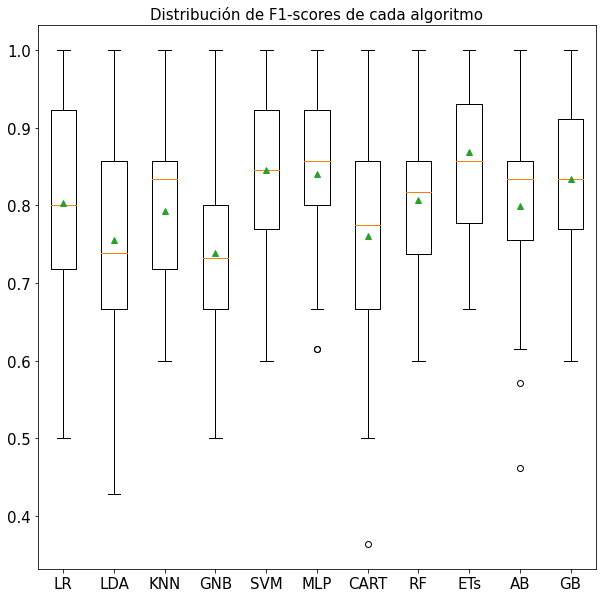

In [24]:
algorithms_names = [
    'LR',
    'LDA',
    'KNN',
    'GNB',
    'SVM',
    'MLP',
    'CART',
    'RF',
    'ETs',
    'AB',
    'GB'
]

fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Distribución de F1-scores de cada algoritmo')
ax.title.set_fontsize(15)

ax.boxplot(best_result_per_algorithm, labels=algorithms_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

La figura anterior confirma el mejor rendimiento de MLP, Extra Trees y Gradient Boosting, al ser quienes alcanzan los F1-scores más altos y las desviaciones más bajas, si bien los boxplots dan cuenta de una alta varianza en los resultados de todos los algoritmos.

#### 5.4.2 Selección de atributos / reducción de dimensionalidad

Ya encontradas las transformaciones de datos que permiten a cada algoritmo obtener el F1-score de prueba promedio más alto, se procede a evaluar cada una de las estrategias de selección de características definidas con anterioridad.

In [26]:
# Define pipelines
best_result_per_pipeline = []

pipelines = [
    
    # Logistic Regression pipeline
    Pipeline([
        ('vt', 'passthrough'),
        ('dt', QuantileTransformer(n_quantiles=130, output_distribution='uniform')),
        ('alg', LogisticRegression())
    ]),
    
    # LDA pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.0001)),
        ('dt', QuantileTransformer(n_quantiles=130, output_distribution='uniform')),
        ('alg', LDA())
    ]),

    # KNN pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.001)),
        ('dt', StandardScaler()),
        ('alg', KNN())
    ]),
    
    # Gaussian Naive Bayes pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.01)),
        ('dt', MaxAbsScaler()),
        ('alg', GNB())
    ]),

    # SVM pipeline
    Pipeline([
        ('vt', 'passthrough'),
        ('dt', QuantileTransformer(n_quantiles=130, output_distribution='uniform')),
        ('alg', SVC())
    ]),

    # MLP pipeline
    Pipeline([
        ('vt', 'passthrough'),
        ('dt', PowerTransformer(method='yeo-johnson')),
        ('alg', MLP)
    ]),
    
    # CART pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.001)), 
        ('alg', CART())
    ]),
    
    # Random Forest pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.001)),
        ('alg', RF())
    ]),
    
    # Extra Trees pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.0001)), 
        ('alg', ET())
    ]),
    
    # Adaboost pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.001)), 
        ('alg', AB())
    ]),
    
    # Gradient boosting pipeline
    Pipeline([
        ('vt', VarianceThreshold(threshold=0.0001)),
        ('alg', GB(random_state=seed))
    ])
]

RFE_estimator = [LogisticRegression(), LDA(), CART(), RF(), ET(), AB(), GB(random_state=seed)]

print('MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE')
print('-------------------------------------------------')
print('')

for (pipeline, num_selected_columns) in zip(pipelines, num_selected_columns_per_algorithm):
    
    # Define all feature selection / dimensionality num_selected_columnspossible configurations for each pipeline
    possible_num_columns = range(10, num_selected_columns, 10)
    
    SelectKBest_combinations = [SelectKBest(k=k) for k in possible_num_columns]
    
    RFE_combinations = []
    for estimator in RFE_estimator:
        for n_features_to_select in possible_num_columns:
            RFE_combinations.append(RFE(estimator=estimator, n_features_to_select=n_features_to_select))
            
    PCA_combinations = [PCA(n_components=n_components) for n_components in possible_num_columns]
    
    fs_methods = ['passthrough'] + SelectKBest_combinations + RFE_combinations + PCA_combinations
    
    best_cv_results = None
    best_test_mean_f1 = float('-inf')
    best_fs_method = None
    
    for fs_method in fs_methods:
        
        with warnings.catch_warnings():
            warnings.simplefilter('error')
            
            try:
                pipeline_temp = clone(pipeline)
                pipeline_temp.steps.insert(-1, ('fs', fs_method))
                
                if type(pipeline_temp['alg']) != KerasClassifier:
                    cv_results = cross_validate(pipeline_temp, X_train, Y_train,
                                                cv=kfold, scoring='accuracy', 
                                                n_jobs=-1, return_train_score=True)
                    
                else:
                    
                    cv_results = {}
                    train_results = []
                    test_results = []
                    
                    for train_index, test_index in kfold.split(X_train, Y_train):
                        
                        X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                        Y_train_kf, Y_test_kf = Y_train[train_index], Y_train[test_index]
                        
                        # Target variable one hot encoding
                        Y_train_kf_ohe = np_utils.to_categorical(Y_train_kf)
                        Y_test_kf_ohe = np_utils.to_categorical(Y_test_kf)
                        
                        pipeline_temp.fit(X_train_kf, Y_train_kf_ohe)
                        predicted_Y_train_kf = pipeline_temp.predict(X_train_kf)
                        predicted_Y_test_kf = pipeline_temp.predict(X_test_kf)
                        
                        train_results.append(f1_score(Y_train_kf, predicted_Y_train_kf))
                        test_results.append(f1_score(Y_test_kf, predicted_Y_test_kf))
                    
                    cv_results['train_score'] = numpy.asarray(train_results)
                    cv_results['test_score'] = numpy.asarray(test_results)
                
                if cv_results['test_score'].mean() > best_test_mean_f1:
                    best_test_mean_f1 = cv_results['test_score'].mean()
                    best_cv_results = cv_results
                    best_fs_method = pipeline_temp['fs']

            except:
                pass
            
    best_test_mean_f1_std = best_cv_results['test_score'].std()
    best_train_mean_f1 = best_cv_results['train_score'].mean()
    best_train_mean_f1_std = best_cv_results['train_score'].std()
    best_list_of_test_f1s = best_cv_results['test_score']
                                            
    best_result_per_pipeline.append(best_list_of_test_f1s)
    
    print('Algoritmo:', pipeline['alg'])
    print('Pipeline limpieza y transformación de datos:', pipeline.steps[:-1])
    print('Selección de características / reducción de dimensionalidad:', best_fs_method)                             
    print('F1-score de entrenamiento promedio:', best_train_mean_f1)
    print('Desviación estándar del F1-score de entrenamiento:', best_train_mean_f1_std)
    print('F1-score de prueba promedio:', best_test_mean_f1)
    print('Desviación estándar del F1-score de prueba:', best_test_mean_f1_std)
    print('')

MEJOR CONFIGURACIÓN ENCONTRADA POR CADA PIPELINE
-------------------------------------------------

Algoritmo: LogisticRegression()
Pipeline limpieza y transformación de datos: [('vt', 'passthrough'), ('dt', QuantileTransformer(n_quantiles=130))]
Selección de características / reducción de dimensionalidad: PCA(n_components=50)
F1-score de entrenamiento promedio: 0.9088119005676257
Desviación estándar del F1-score de entrenamiento: 0.010539897999362592
F1-score de prueba promedio: 0.833015873015873
Desviación estándar del F1-score de prueba: 0.09158826441682563

Algoritmo: LinearDiscriminantAnalysis()
Pipeline limpieza y transformación de datos: [('vt', VarianceThreshold(threshold=0.0001)), ('dt', QuantileTransformer(n_quantiles=130))]
Selección de características / reducción de dimensionalidad: RFE(estimator=LogisticRegression(), n_features_to_select=30)
F1-score de entrenamiento promedio: 0.9172440790761399
Desviación estándar del F1-score de entrenamiento: 0.012235029826788757
F1-sco

Los resultados muestran que todos los algoritmos lograron mejorar sus resultados gracias a la selección de características o a la reducción de dimensionalidad, de tal manera que los F1-scores de prueba promedio experimentaron aumentos entre 0,01 y 0,07, al mismo tiempo que sus desviaciones estándar se redujeron levemente. Los niveles de sobreajuste también disminuyeron, pero siguen siendo significativos.

No obstante, el hecho más destacable de esta sección es que tanto SVM como Gradient Boosting logran superar el F1-score de prueba promedio de MLP, relegando a este último al cuarto lugar en el ranking de rendimiento. Por otra parte, Extra Trees continúa siendo el mejor algoritmo.

Para una mejor visualización de los resultados, se construye, por cada pipeline, un boxplot con sus distribuciones de F1-scores en base a las mejores preparaciones (transformación de atributos + selección de características / reducción de dimensionalidad) de datos encontradas para cada uno.

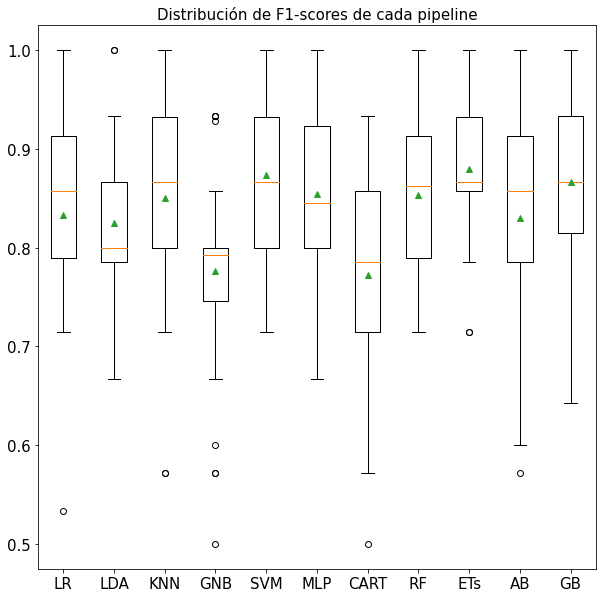

In [27]:
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Distribución de F1-scores de cada pipeline')
ax.title.set_fontsize(15)

ax.boxplot(best_result_per_pipeline, labels=algorithms_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

La figura ratifica que Extra Trees, SVM y Gradient Boosting son los algoritmos de mejor rendimiento al obtener, en promedio, los F1-scores de prueba más alto. Además, se observa un importante aumento en la varianza de los resultados de MLP.

Ya estudiadas las diferentes preparaciones de datos posibles, se procede a seleccionar los tres algoritmos que, en conjunto con preparaciones determinadas, obtienen los F1-score de prueba promedio más altos para así sintonizar sus hiperparámetros. Dichos algoritmos son:

1. Extra Trees
    - ¿Eliminación de columnas con baja varianza?: Sí, aquellas con varianza menor a 0.0001, reteniendo así 50 atributos. 
    - Transformación de datos: Ninguna.
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de RFE, seleccionando los 30 atributos más relevantes según AdaBoost.
    

2. SVM
    - ¿Eliminación de columnas con baja varianza?: No.
    - Transformación de datos: Quantile Transform, usando 130 cuantiles y con distribución de salida uniforme.
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de PCA, seleccionando las 20 componentes principales.


3. Gradient Boosting
    - ¿Eliminación de columnas con baja varianza?: Sí, aquellas con varianza menor a 0.0001, reteniendo así 50 atributos. 
    - Transformación de datos: Ninguna.
    - ¿Selección de características / reducción de dimensionalidad?: Sí, por medio de RFE, seleccionando los 40 atributos más relevantes según AdaBoost.

## 6. Mejora de resultados

### 6.1 Sintonización de hiperparámetros

#### 6.1.1 Extra Trees

- Para el número de árboles, se considerarán los valores 100, 200, 500, 1000 y 5000.

- Para la profundidad máxima de cada árbol, se considerarán valores entre entre 10 y 100, con aumentos de 30 en 30, y también se evaluará el efecto de no aplicar ninguna restricción sobre este hiperparámetro (None).

- Para el número mínimo de observaciones que deben existir en cada nodo de división, se considerarán los valores 2, 5 y 10.

- Para el número mínimo de observaciones que deben existir en un nodo hoja, se considerarán los valores 1, 2, 5 y 10.

- Para el número máximo de atributos a ser considerados en cada nodo de división, se considerarán tanto la raíz cuadrada como el logaritmo en base 2 del número total de atributos.

- Se evaluará el efecto de conformar el conjunto de entrenamiento de cada árbol mediante bootstrap o simplemente utilizar el conjunto de entrenamiento completo en cada uno de ellos.

Notar que por temas de eficiencia en términos de tiempo de cómputo, se usará Random Search para la búsqueda de los hiperparámetros, con 60 iteraciones, lo que en consecuencia no garantiza encontrar la solución óptima. En caso de que dicha solución obtenga un F1-score de prueba promedio menor al de la configuración por defecto, se mantendrán los hiperparámetros de esta última.

In [28]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE EXTRA TREES')
print('-----------------------------------------------')
print('')

# Extra Trees hyperparameter tuning
et_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=30)),
    ('et', ET())
])

et_param_grid = {
    'et__n_estimators': [100, 200, 500, 1000, 5000],
    'et__max_depth': [d for d in range(10, 130, 30)] + [None],
    'et__min_samples_split': [2, 5, 10],
    'et__min_samples_leaf': [1, 2, 5, 10],
    'et__max_features': ['sqrt', 'log2'],
    'et__bootstrap': [True, False]
}

et_search = RandomizedSearchCV(et_pipeline, et_param_grid, n_iter=60,
                               scoring='f1', cv=kfold, n_jobs=-1,
                               return_train_score=True)

# et_search = RandomizedSearchCV(et_pipeline, et_param_grid, n_iter=60,
#                                scoring='f1', cv=kfold, n_jobs=-1,
#                                return_train_score=True, random_state=seed)

et_results = et_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', et_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     et_results.cv_results_['mean_train_score'][et_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      et_results.cv_results_['std_train_score'][et_results.best_index_])
print('F1-Score promedio de prueba:', et_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      et_results.cv_results_['std_test_score'][et_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE EXTRA TREES
-----------------------------------------------

Mejores hiperparámetros encontrados: {'et__n_estimators': 100, 'et__min_samples_split': 2, 'et__min_samples_leaf': 1, 'et__max_features': 'log2', 'et__max_depth': 70, 'et__bootstrap': False}
F1-Score promedio de entrenamiento: 1.0
Desviación estándar del F1-Score de entrenamiento: 0.0
F1-Score promedio de prueba: 0.8703180153180152
Desviación estándar del F1-Score de prueba: 0.0972514181451352


Los resultados muestran que el F1-score de prueba promedio es de 0.87, siendo levemente inferior al 0.88 alcanzado por la configuración estándar del algoritmo. Así, para efectos comparativos, se mantendrá esta última configuración.

Luego, los mejores resultados se obtienen con los siguientes hiperparámetros:

- Número de árboles: 100.
- Profundidad máxima de cada árbol: None (no hay límite para la profundidad máxima).
- Número mínimo de observaciones por nodo de división: 2. 
- Número mínimo de observaciones por nodo hoja: 1.
- Número máximo de atributos a considerar por nodo de división: 'sqrt' (raíz cuadrada de número total de atributos).
- ¿Uso de bootstrap?: False (no hay uso de bootstrap).

#### 6.1.2 SVM

- Se considerarán los siguientes valores para el parámetro de regularización C: 0.001, 0.01, 0.1, 1.0, 10.0, 100.0 y 1000.0.
- Se evaluarán diferentes kernels: lineal, RBF, sigmoid y polinomial.
- Para los kernels RBF, sigmoid y polinomial, se evaluarán diferentes valores de gamma: 0.0001, 0.001, 0.01, 0.1, 1.0 y 10.0, así como también las estrategias 'scale' y 'auto' que provee sklearn.
- Para el kernel polinomial, se considerarán diferentes grados entre 2 y 6.

In [17]:
print('SINTONIZACIÓN DE PARÁMETROS DE SVM')
print('----------------------------------')
print('')

# SVM hyperparameter tuning
svm_pipeline = Pipeline([
    ('vt', 'passthrough'),
    ('dt', QuantileTransformer(n_quantiles=130, output_distribution='uniform')),
    ('fs', PCA(n_components=20)),
    ('svm', SVC())
])

svm_param_grid = [
    {
        'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svm__kernel': ['linear'],
    },
    
    {
        'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svm__kernel': ['rbf', 'sigmoid'],
        'svm__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] 
    },
    
    {
        'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'svm__kernel': ['poly'],
        'svm__degree': [2, 3, 4, 5, 6],
        'svm__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] 
    }
]

svm_search = GridSearchCV(svm_pipeline, svm_param_grid, scoring='f1', 
                          cv=kfold, n_jobs=-1, return_train_score=True)

svm_results = svm_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', svm_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     svm_results.cv_results_['mean_train_score'][svm_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      svm_results.cv_results_['std_train_score'][svm_results.best_index_])
print('F1-Score promedio de prueba:', svm_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      svm_results.cv_results_['std_test_score'][svm_results.best_index_])

SINTONIZACIÓN DE PARÁMETROS DE SVM
----------------------------------

Mejores hiperparámetros encontrados: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
F1-Score promedio de entrenamiento: 1.0
Desviación estándar del F1-Score de entrenamiento: 0.0
F1-Score promedio de prueba: 0.8735225885225885
Desviación estándar del F1-Score de prueba: 0.09125658203025332


Luego, el mejor resultado para SVM se da con C = 10, kernel RBF y gamma = 'scale',  de tal manera que su F1-score de prueba promedio aumenta en aproximadamente 0,01. Al mismo tiempo, la desviación estándar de esta métrica se reduce levemente, de 0,09 a 0,08.

#### 6.1.3 Gradient Boosting

Considerando la alta cantidad de hiperparámetros que posee este algoritmo, se dividirá el proceso de sintonización de los mismos en 5 fases:

- Fase 1: Sintonización de número de árboles y taza de aprendizaje
    - Para el número de árboles, se considerarán los valores 100, 200, 500, 1000 y 5000.
    - Para la tasa de aprendizaje eta se considerarán los valores 0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3.
    
    

- Fase 2: Sintonización de profundidad máxima de cada árbol y min_child_weight
    - Para la profundidad máxima de los árboles, se considerarán valores entre entre 2 y 8, con aumentos de 2 en 2.
    - Para min_child_weight (esto es, el valor mínimo de la suma de los pesos en un nodo hijo), se considerarán los valores 1, 3, 5 y 7.
    
 
- Fase 3: Sintonización de gamma
    - Para el parámetro gamma, se considerarán: el valor 0.0, valores en el rango [0.05, 0.1], con aumentos de 0.01, y valores en el rango [0.3, 0.9], con aumentos de 0.2, y el valor 1.0.


- Fase 4: Sintonización de proporciones de submuestreo
    - Para la proporción de submuestreo de filas de cada árbol, se considerarán valores entre 0.5 y 1.0, con aumentos de 0.1 en 0.1.
    - Para la proporción de submuestreo de columnas de cada árbol, se considerarán valores entre 0.5 y 1.0, con aumentos de 0.1 en 0.1.
    - Para la proporción de submuestreo de columnas por cada nodo de división, se considerarán valores entre 0.5 y 1.0, con aumentos de 0.1 en 0.1.
    

- Fase 5: Sintonización de alpha y lambda (hiperparámetros de regularización)
    - Para el parámetro lambda, se considerarán los valores 0.0, 0.00001, 0.01, 0.1, 1.0, 100.0.
    - Para el parámetro alpha, se considerarán los valores 0.0, 0.00001, 0.01, 0.1, 1.0, 100.0.
    
Se comienza, entonces, con la fase 1:

In [ ]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING')
print('PARTE 1: SINTONIZACIÓN DE NÚMERO DE ÁRBOLES Y TASA DE APRENDIZAJE')
print('-----------------------------------------------------------------')
print('')

# Gradient Boosting hyperparameter tuning
gb_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=40)),
    ('gb', GB(random_state=seed))
])

gb_param_grid = {
    'gb__n_estimators': [100, 200, 500, 1000, 5000],
    'gb__eta': [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}

gb_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='f1', 
                         cv=kfold, n_jobs=-1,
                         return_train_score=True)

gb_results = gb_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', gb_results.best_params_)
print('F1-Score promedio de prueba:', gb_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      gb_results.cv_results_['std_test_score'][gb_results.best_index_])

Luego, el mejor resultado se obtiene con 200 árboles y tasa de aprendizaje de 0.2. Usando los dos valores anteriores, se sintoniza la profundidad máxima de cada árbol y min_child_weight.

In [19]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING')
print('PARTE 2: SINTONIZACIÓN DE PROFUNDIDAD MÁXIMA Y MIN_CHILD_WEIGHT')
print('---------------------------------------------------------------')
print('')

# Gradient Boosting hyperparameter tuning
gb_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=40)),
    ('gb', GB(n_estimators=200, eta=0.2, random_state=seed))
])

gb_param_grid = {
    'gb__max_depth': [d for d in range(2, 10, 2)],
    'gb__min_child_weight': [w for w in range(1, 9, 2)]
}

gb_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='f1', 
                         cv=kfold, n_jobs=-1,
                         return_train_score=True)

gb_results = gb_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', gb_results.best_params_)
print('F1-Score promedio de prueba:', gb_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      gb_results.cv_results_['std_test_score'][gb_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING
PARTE 2: SINTONIZACIÓN DE PROFUNDIDAD MÁXIMA Y MIN_CHILD_WEIGHT
---------------------------------------------------------------

Mejores hiperparámetros encontrados: {'gb__max_depth': 2, 'gb__min_child_weight': 3}
F1-Score promedio de prueba: 0.8478484478484477
Desviación estándar del F1-Score de prueba: 0.09189647213788589


Así, el mejor resultado se obtiene con una profundidad máxima por árbol de 2 y min_child_weight de 3. Con esto en mente, se procede a sintonizar el valor de gamma.

In [21]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING')
print('PARTE 3: SINTONIZACIÓN DE GAMMA')
print('-----------------------------------------------------')
print('')

gb_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=40)),
    ('gb', GB(n_estimators=200, eta=0.2, max_depth=2, 
              min_child_weight=3, random_state=seed))
])

gb_param_grid = {
    'gb__gamma': [0.0] + [g for g in numpy.arange(0.05, 0.11, 0.01)] + [g for g in numpy.arange(0.3, 1.1, 0.2)] + [1.0]
}

gb_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='f1', 
                         cv=kfold, n_jobs=-1,
                         return_train_score=True)

gb_results = gb_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', gb_results.best_params_)
print('F1-Score promedio de prueba:', gb_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      gb_results.cv_results_['std_test_score'][gb_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING
PARTE 3: SINTONIZACIÓN DE GAMMA
-----------------------------------------------------

Mejores hiperparámetros encontrados: {'gb__gamma': 0.0}
F1-Score promedio de prueba: 0.8488277463277464
Desviación estándar del F1-Score de prueba: 0.13198177124271798


El mejor resultado es obtenido con el valor por defecto de gamma, 0.0. Se continúa con la sintonización de las proporciones de submuestreo. Notar que dada la alta cantidad de combinaciones posibles, se usará Random Search, nuevamente con 60 iteraciones.

In [22]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING')
print('PARTE 4: SINTONIZACIÓN DE PROPORCIONES DE SUBMUESTREO')
print('-----------------------------------------------------')
print('')

gb_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=40)),
    ('gb', GB(n_estimators=200, eta=0.2, max_depth=2, 
              min_child_weight=3, gamma=0.0, 
              random_state=seed))
])

gb_param_grid = {
    'gb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gb__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gb__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gb_search = RandomizedSearchCV(gb_pipeline, gb_param_grid, n_iter=60, 
                               scoring='f1', cv=kfold, n_jobs=-1,
                               return_train_score=True)

# gb_search = RandomizedSearchCV(gb_pipeline, gb_param_grid, n_iter=60, 
#                                scoring='f1', cv=kfold, n_jobs=-1,
#                                return_train_score=True, random_state=seed)

gb_results = gb_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', gb_results.best_params_)
print('F1-Score promedio de prueba:', gb_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      gb_results.cv_results_['std_test_score'][gb_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING
PARTE 4: SINTONIZACIÓN DE PROPORCIONES DE SUBMUESTREO
-----------------------------------------------------

Mejores hiperparámetros encontrados: {'gb__subsample': 0.9, 'gb__colsample_bytree': 0.9, 'gb__colsample_bylevel': 0.5}
F1-Score promedio de prueba: 0.8709450843274372
Desviación estándar del F1-Score de prueba: 0.09235868085997165


Así, la mejor combinación de valores encontrada por Random Search implica el uso del 90% de las observaciones y el 90% de los atributos en la conformación de cada árbol, además del uso del 50% de las columnas en cada punto de división.

Finalmente, se sintonizan los valores de los hiperparámetros de regularización lambda y alpha.

In [23]:
print('SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING')
print('PARTE 5: SINTONIZACIÓN DE LAMBDA Y ALPHA')
print('--------------------------------------------------------')
print('')

gb_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.0001)),
    ('dt', 'passthrough'),
    ('fs', RFE(estimator=AB(), n_features_to_select=40)),
    ('gb', GB(n_estimators=200, eta=0.2, max_depth=2, 
              min_child_weight=3, gamma=0.0, 
              subsample=0.9, 
              colsample_bytree=0.9, 
              colsample_bylevel=0.5, 
              random_state=seed))
])

gb_param_grid = {
    'gb__lambda': [0.0, 0.00001, 0.01, 0.1, 1.0, 100.0],
    'gb__alpha': [0.0, 0.00001, 0.01, 0.1, 1.0, 100.0]
}

gb_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='f1', 
                         cv=kfold, n_jobs=-1,
                         return_train_score=True)

gb_results = gb_search.fit(X_train, Y_train)

print('Mejores hiperparámetros encontrados:', gb_results.best_params_)
print('F1-Score promedio de entrenamiento:',
     gb_results.cv_results_['mean_train_score'][gb_results.best_index_])
print('Desviación estándar del F1-Score de entrenamiento:', 
      gb_results.cv_results_['std_train_score'][gb_results.best_index_])
print('F1-Score promedio de prueba:', gb_results.best_score_)
print('Desviación estándar del F1-Score de prueba:', 
      gb_results.cv_results_['std_test_score'][gb_results.best_index_])

SINTONIZACIÓN DE HIPERPARÁMETROS DE GRADIENT BOOSTING
PARTE 5: SINTONIZACIÓN DE LAMBDA Y ALPHA
--------------------------------------------------------

Mejores hiperparámetros encontrados: {'gb__alpha': 0.0, 'gb__lambda': 0.1}
F1-Score promedio de entrenamiento: 1.0
Desviación estándar del F1-Score de entrenamiento: 0.0
F1-Score promedio de prueba: 0.8523451548451549
Desviación estándar del F1-Score de prueba: 0.09261003865472683


Luego, el mejor resultado encontrado para Gradient Boosting, se da con los siguientes hiperparámetros:

- Número de árboles: 200.
- Tasa de aprendizaje eta: 0.2.
- Profundidad máxima por árbol: 2.
- Valor mínimo de la suma de los pesos de cada nodo hijo: 3.
- Gamma: 0.0.
- Proporción de submuestreo de filas por árbol: 0.9.
- Proporción de submuestreo de columnas por árbol: 0.9.
- Proporción de submuestreo de columnas por nodo de división: 0.5.
- Lambda: 0.1.
- Alpha: 0.0.

Para ilustrar mejor los resultados obtenidos durante el proceso de sintonización, se construye un boxplot por cada mejor configuración encontrada:

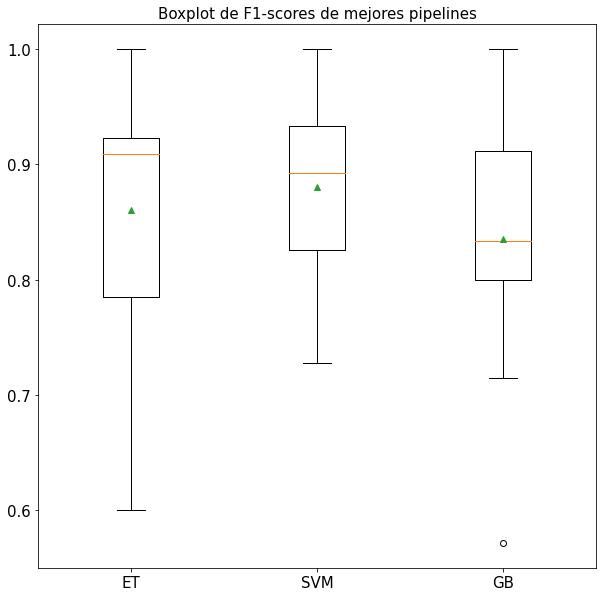

In [18]:
best_pipelines = [
    
    ('best_et_pipeline', Pipeline([
        ('vt', VarianceThreshold(threshold=0.0001)),
        ('dt', 'passthrough'),
        ('fs', RFE(estimator=AB(), n_features_to_select=30)),
        ('et', ET())
    ])),
    
    ('best_svm_pipeline', Pipeline([
        ('vt', 'passthrough'),
        ('dt', QuantileTransformer(n_quantiles=130, output_distribution='uniform')),
        ('fs', PCA(n_components=20)),
        ('svm', SVC(C=10, kernel='rbf', gamma='scale', probability=True))
    ])),
    
    ('best_gb_pipeline', Pipeline([
        ('vt', VarianceThreshold(threshold=0.0001)),
        ('dt', 'passthrough'),
        ('fs', RFE(estimator=AB(), n_features_to_select=40)),
        ('gb', GB(n_estimators=200, eta=0.2, max_depth=2, 
                  min_child_weight=3, gamma=0.0, 
                  subsample=0.9,
                  colsample_bytree=0.9, 
                  colsample_bylevel=0.5,
                  alpha=0.0, reg_lambda=0.1, 
                  random_state=seed))
    ]))
]

best_pipelines_names = ['ET', 'SVM', 'GB']
best_pipelines_results = []

for _, best_pipeline in best_pipelines:
    best_pipeline_cv_results = cross_validate(best_pipeline, X_train, Y_train, 
                                              cv=kfold, scoring='f1', n_jobs=-1)
    
    best_pipelines_results.append(best_pipeline_cv_results['test_score'])

fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Boxplot de F1-scores de mejores pipelines')
ax.title.set_fontsize(15)

ax.boxplot(best_pipelines_results, labels=best_pipelines_names, showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

La figura muestra que, en efecto, cada configuración alcanza, en promedio, un alto valor de F1-score de prueba. Sin embargo, también es posible observar que se obtienen desviaciones estándar bastante altas en cada caso, donde la más baja se da para SVM. Así, con el objetivo de conseguir mejoras en los resultados, tanto en términos de un posible aumento de F1-score como de una posible reducción de la desviación de esta métrica, se estudiarán diferentes estrategias de ensamblado en la siguiente sección. 

### 6.2 Ensamblado de modelos

Se evaluarán tres técnicas diferentes de ensamblado de modelos:

- Hard Voting
- Soft Voting
- Stacking Generalization

En cada caso, los estimadores serán aquellos que fueron sintonizados en la sección 6.1 (Extra Trees, SVM y Gradient Boosting).

#### 6.2.1 Hard Voting

A continuación, se construye un ensamblado de tipo hard voting a partir de los estimadores antes mencionados.

In [20]:
# Define the hard voting ensemble
hv_ensemble = VotingClassifier(estimators=best_pipelines, voting='hard')

# Evaluate the ensemble
hv_cv_results = cross_validate(hv_ensemble, X_train, Y_train, cv=kfold, 
                               scoring='f1', n_jobs=-1, 
                               return_train_score=True)

print('EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (HARD VOTING)')
print('--------------------------------------------------------')
print('')

print('F1-score de entrenamiento promedio:', hv_cv_results['train_score'].mean())
print('Desviación estándar del F1-score de entrenamiento:', hv_cv_results['train_score'].std())
print('F1-score de prueba promedio:', hv_cv_results['test_score'].mean())
print('Desviación estándar del F1-score de prueba:', hv_cv_results['test_score'].std())

EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (HARD VOTING)
--------------------------------------------------------

F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.8673273948273948
Desviación estándar del F1-score de prueba: 0.09527447135458499


Los resultados muestran que el ensamblado alcanza un F1-score de prueba promedio superior al de Gradient Boosting, pero inferior a los de Extra Trees y SVM. Además, no logra reducir la desviación estándar de la métrica, siendo de hecho bastante similar a las de los mencionados algoritmos.

#### 6.2.2 Soft Voting

Se construye un ensamblado de tipo soft voting a partir de los estimadores previamente definidos.

In [21]:
# Define the soft voting ensemble
sv_ensemble = VotingClassifier(estimators=best_pipelines, voting='soft')

# Evaluate the ensemble
sv_cv_results = cross_validate(sv_ensemble, X_train, Y_train, cv=kfold, 
                               scoring='f1', n_jobs=-1, 
                               return_train_score=True)

print('EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (SOFT VOTING)')
print('--------------------------------------------------------')
print('')

print('F1-score de entrenamiento promedio:', sv_cv_results['train_score'].mean())
print('Desviación estándar del F1-score de entrenamiento:', sv_cv_results['train_score'].std())
print('F1-score de prueba promedio:', sv_cv_results['test_score'].mean())
print('Desviación estándar del F1-score de prueba:', sv_cv_results['test_score'].std())

EVALUACIÓN DE ENSAMBLADO VOTING CLASSIFIER (SOFT VOTING)
--------------------------------------------------------

F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.8878665778665779
Desviación estándar del F1-score de prueba: 0.0977937280488776


En este caso, el ensamblado alcanza un F1-score de prueba promedio cercano a 0.89, superior al de los tres estimadores base. Sin embargo, su desviación estándar continúa siendo bastante similar a las de dichos estimadores.

#### 6.2.3 Stacking Generalization

Se utilizará Regresión Logística como meta-modelo. Notar, además, que dicho meta-modelo usará internamente un esquema de 10-fold cross validation para la generación del conjunto de entrenamiento que recibirá como input.

Se evaluarán dos posibles estructuras para el conjunto de entrenamiento que recibe el meta-modelo:

1. Cada observación estará definida por sus atributos originales y por las predicciones realizadas por cada estimador para dicha observación.

2. Cada observación está integrada sólo por las predicciones realizadas por cada estimador.

In [16]:
best_pipelines[1] = ('best_svm_pipeline', Pipeline([
    ('vt', 'passthrough'),
    ('dt', QuantileTransformer(n_quantiles=117, output_distribution='uniform')),
    ('fs', PCA(n_components=20)),
    ('svm', SVC(C=10, kernel='rbf', gamma='scale', probability=True))
]))

stacking_results = []

print('EVALUACIÓN DE ENSAMBLADO STACKING')
print('--------------------------------------------------------')
print('')

for passthrough in [True, False]:
    
    if passthrough:
        print('USANDO TANTO PREDICCIONES DE MODELOS BASE COMO INPUTS ORIGINALES')
    else:
        print('USANDO SÓLO PREDICCIONES DE MODELOS BASE')
        
    print('-----------------------------------------------------------------')
    print('')
     
    # Define the stacking ensemble
    stacking_ensemble = StackingClassifier(estimators=best_pipelines, cv=10, 
                                           n_jobs=-1, passthrough=passthrough)

    # Evaluate the ensemble
    stacking_cv_results = cross_validate(stacking_ensemble, X_train, Y_train, 
                                         cv=kfold, scoring='accuracy', n_jobs=-1,
                                         return_train_score=True)
    
    stacking_results.append(stacking_cv_results['test_score'])
        
    print('F1-score de entrenamiento promedio:', stacking_cv_results['train_score'].mean())
    print('Desviación estándar del F1-score de entrenamiento:', stacking_cv_results['train_score'].std())
    print('F1-score de prueba promedio:', stacking_cv_results['test_score'].mean())
    print('Desviación estándar del F1-score de prueba:', stacking_cv_results['test_score'].std())
    print('')

EVALUACIÓN DE ENSAMBLADO STACKING
--------------------------------------------------------

USANDO TANTO PREDICCIONES DE MODELOS BASE COMO INPUTS ORIGINALES
-----------------------------------------------------------------

F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.8825396825396826
Desviación estándar del F1-score de prueba: 0.05101143786096392
USANDO SÓLO PREDICCIONES DE MODELOS BASE
-----------------------------------------------------------------

F1-score de entrenamiento promedio: 1.0
Desviación estándar del F1-score de entrenamiento: 0.0
F1-score de prueba promedio: 0.8801587301587301
Desviación estándar del F1-score de prueba: 0.07371046433363566


Los resultados muestran que el mejor F1-score de prueba promedio se obtiene al alimentar el meta-modelo tanto con los inputs originales como con las predicciones realizadas por los estimadores base. Este F1-score, cercano a 0.88, es superior al de todos los estimadores y, si bien es levemente inferior al de Soft Voting, también logra reducir en forma importante la desviación estándar de la métrica, siendo esta de aproximadamente 0.05, bastante inferior a la desviación estándar cercana a 0.1 observada en los casos anteriores.

A continuación, se construyen boxplots con las distribuciones de F1-score de prueba promedio de cada ensamblado y de cada estimador que lo integra.

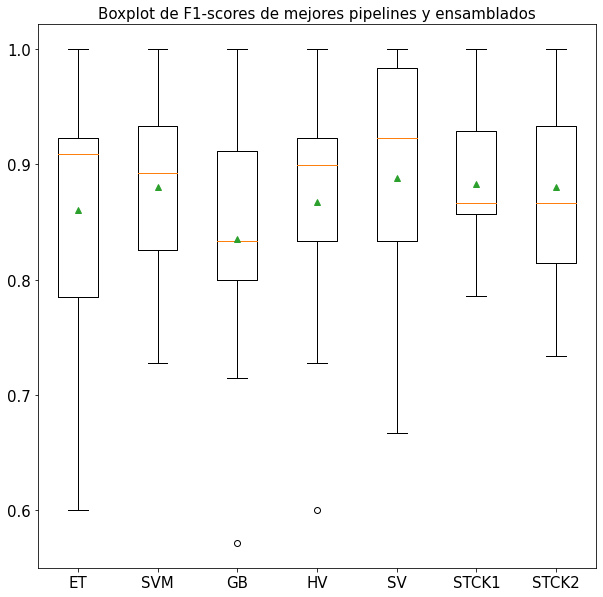

In [22]:
best_pipelines_and_ensembles_names = best_pipelines_names + ['HV', 'SV', 'STCK1', 'STCK2']

best_pipelines_and_ensembles_results = best_pipelines_results + [hv_cv_results['test_score'],
                                                                 sv_cv_results['test_score']] + stacking_results

fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title('Boxplot de F1-scores de mejores pipelines y ensamblados')
ax.title.set_fontsize(15)

ax.boxplot(best_pipelines_and_ensembles_results, 
           labels=best_pipelines_and_ensembles_names, 
           showmeans=True)

for algorithm_label in ax.get_xticklabels():
    algorithm_label.set_fontsize(15)
    
for accuracy_label in ax.get_yticklabels():
    accuracy_label.set_fontsize(15)

pyplot.show()

La figura reafirma la idea de que el primer ensamblado de tipo stacking (STCK1) consigue, en promedio, uno de los F1-score de prueba más altos y al mismo tiempo logra reducir en forma considerable la desviación estándar de esta métrica.

Con estos antecedentes sobre la mesa, se procede a escoger a STCK1 como el modelo final.

## 7. Evaluación de modelo final sobre conjunto de validación

Con el fin de comprobar su habilidad, el modelo final será entrenado sobre el conjunto de entrenamiento y posteriormente será evaluado sobre el conjunto de validación. Esto será una importante muestra del verdadero poder predictivo del modelo seleccionado, ya que el conjunto de validación no ha sido utilizado en ninguna de las fases previas del proyecto, y por tanto, las observaciones que lo integran no han sido vistas por el modelo en cuestión.

Recordar que en la sección 6.2.1 se ha estimado el rendimiento de STCK1 sobre datos no vistos por medio de Repeated stratified 10-fold cross validation (con número de repeticiones igual a tres). Dicha estimación está dada por los siguientes valores:

- F1-score de entrenamiento: 1.0
- F1-score de prueba: 0.88

Luego, se procede a implementar el procedimiento descrito:

In [23]:
# Evaluate stacking ensemble over validation set
stacking_ensemble = StackingClassifier(estimators=best_pipelines, cv=10, 
                                       n_jobs=-1, passthrough=True)

stacking_ensemble.fit(X_train, Y_train)

predicted_Y_train = stacking_ensemble.predict(X_train)
predicted_Y_validation = stacking_ensemble.predict(X_validation)
                        
print('F1-score de entrenamiento:', f1_score(Y_train, predicted_Y_train))
print('F1-score de validación:', f1_score(Y_validation, predicted_Y_validation))

F1-score de entrenamiento: 1.0
F1-score de validación: 0.9


Se observa que el F1-score de validación alcanzado por el modelo, de 0.90, es superior en 0.02 al F1-score estimado, de 0.88. En consecuencia, el sobreajuste del modelo también es menor a lo esperado, de tal manera que la diferencia entre los F1-scores de entrenamiento y de validación es de 0.10, en vez de 0.12

Luego, los resultados obtenidos son lo suficientemente satisfactorios como para confirmar la elección del ensamblado de tipo Stacking Generalization como el modelo final.

## 8. Finalización de modelo seleccionado

Se procede a entrenar el modelo seleccionado sobre el conjunto de datos completo para luego guadarlo en disco y eventualmente utilizarlo en futuras predicciones.

In [24]:
# Finalize the selected model
stacking_ensemble.fit(X, Y)

# Save the model to disk
with open('STCK1.pickle', 'wb') as model_file:
    pickle.dump(stacking_ensemble, model_file)

## 9. Presentación de resultados

Los experimentos llevados a cabo a lo largo de este proyecto han permitido encontrar un modelo que, al ser entrenado sobre un conjunto de observaciones previamente estratificado sobre la variable dependiente e integrado por el 70% del total de observaciones disponibles, obtiene un F1-score de 0.90 sobre el 30% de instancias previamente no observadas. Dicho modelo corresponde a un ensamblado de tipo Stacking Generalization, integrado por los siguientes estimadores:

- Extra Trees, con hiperparámetros por defecto, cuyos pasos de preparación de datos asociados son:
    - Eliminación de atributos cuya varianza es inferior a 0.0001, reteniendo así 50 de las columnas originales.
    - Selección de los 30 atributos más importantes por medio de RFE, con AdaBoost como el estimador de las importancias.
    
    
- SVM, con hiperparámetros por defecto (excepto por parámetro de regularización C=10), cuyos pasos de preparación de datos asociados son:
    - Aplicación de Quantile Transform sobre atributos, utilizando 117 cuantiles y con distribución de salida uniforme.
    - Reducción de dimensionalidad por medio de PCA, conservando las 20 componentes principales.
    
    
- <b>Gradient Boosting</b>, configurado con los siguientes hiperparámetros:
    - Número de árboles: 200.
    - Tasa de aprendizaje eta: 0.2.
    - Profundidad máxima por árbol: 2.
    - Valor mínimo de la suma de los pesos de cada nodo hijo (min_child_weight): 3.
    - Gamma: 0.0.
    - Proporción de submuestreo de filas por árbol: 0.9.
    - Proporción de submuestreo de columnas por árbol: 0.9.
    - Proporción de submuestreo de columnas por nodo de división: 0.5.
    - Lambda: 0.1.
    - Alpha: 0.0.

    Y cuyos pasos de preparación de datos asociados son:
    - Eliminación de atributos cuya varianza es inferior a 0.0001, reteniendo así 50 de las columnas originales.
    - Selección de los 40 atributos más importantes por medio de RFE, con AdaBoost como el estimador de las importancias.